In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/P-B/Data
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Model,Sequential
import tensorflow.keras.regularizers as regularizers
from tensorflow.keras.utils import plot_model
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import os
import PIL
import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras import regularizers

Mounted at /content/drive
/content/drive/MyDrive/P-B/Data


In [2]:
dataset_url = "/content/drive/MyDrive/P-B/Data"
data_dir = pathlib.Path(dataset_url)
print(data_dir)


/content/drive/MyDrive/P-B/Data


In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3792


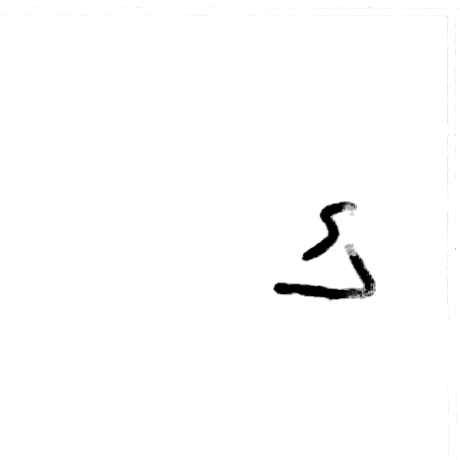

In [4]:
chars01 = list(data_dir.glob('01/*'))
PIL.Image.open(str(chars01[1]))

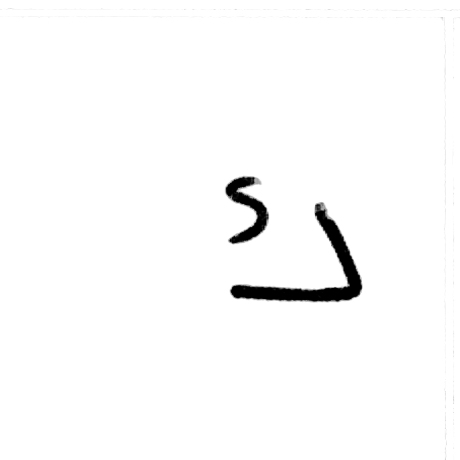

In [5]:
PIL.Image.open(str(chars01[0]))

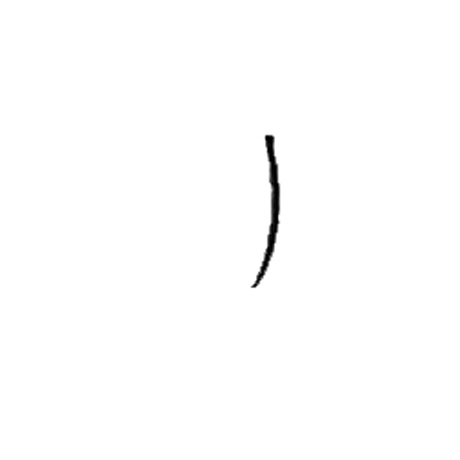

In [6]:
chars02 = list(data_dir.glob('02/*'))
PIL.Image.open(str(chars02[0]))

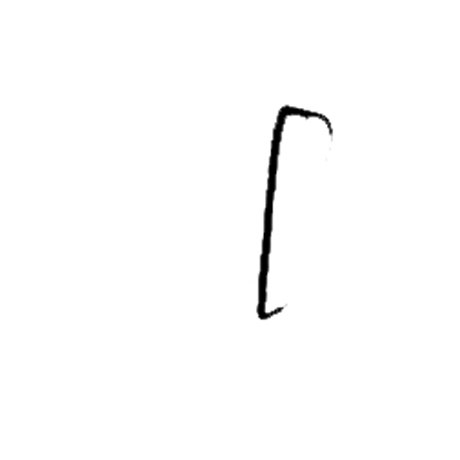

In [7]:
PIL.Image.open(str(chars02[1]))

In [8]:
batch_size = 32
img_height = 180
img_width = 180

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3792 files belonging to 36 classes.
Using 3034 files for training.


In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3792 files belonging to 36 classes.
Using 758 files for validation.


In [11]:
class_names = train_ds.class_names
print(class_names)

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', 'logs']


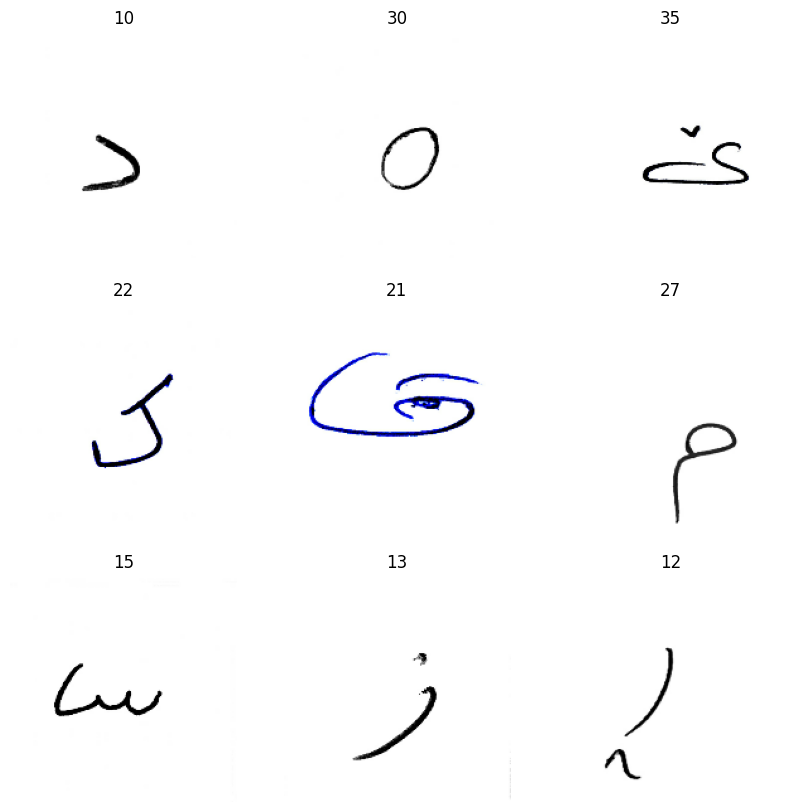

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [15]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [16]:
num_classes = len(class_names)
# Define the model
model = Sequential([
    # Input layer
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    # Convolutional layers with Batch Normalization and ReLU activation
    Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),

    Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),

    Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),

    # Flatten the output to feed into Dense layers
    Flatten(),

    # Dense layers with Dropout and ReLU activation
    Dense(256, kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),

    Dense(128, kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),

    # Output layer with softmax activation for multi-class classification
    Dense(num_classes, activation='softmax')
])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 180, 180, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 180, 180, 32)     128       
 hNormalization)                                        

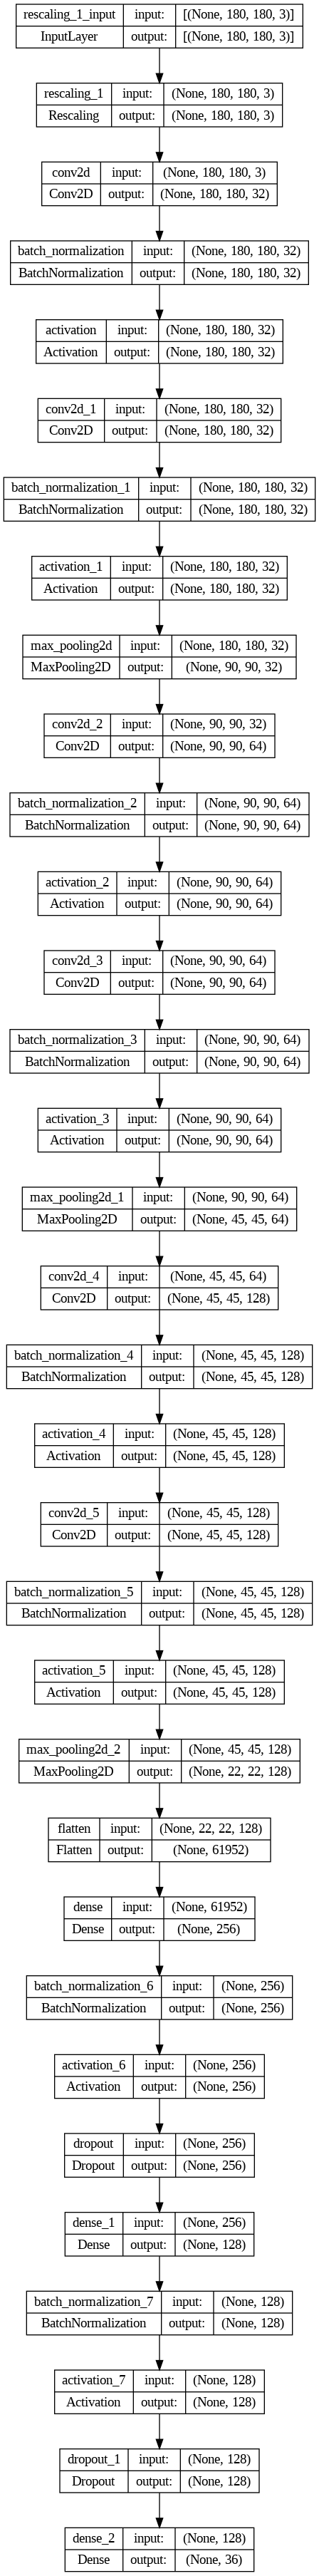

In [18]:
plot_model(model, show_shapes=True)

In [19]:
with tf.device("/gpu:0"):
    model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

In [20]:
epochs=10
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[es_callback,tensorboard_callback]
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


95/95 [==============================] - 98s 848ms/step - loss: 4.7606 - accuracy: 0.0972 - val_loss: 5.5740 - val_accuracy: 0.0343
Epoch 2/10
95/95 [==============================] - 16s 173ms/step - loss: 4.0152 - accuracy: 0.2014 - val_loss: 6.3677 - val_accuracy: 0.0488
Epoch 3/10
95/95 [==============================] - 15s 161ms/step - loss: 3.6411 - accuracy: 0.3003 - val_loss: 6.2767 - val_accuracy: 0.0475
Epoch 4/10
95/95 [==============================] - 16s 164ms/step - loss: 3.2561 - accuracy: 0.4235 - val_loss: 4.7216 - val_accuracy: 0.1055
Epoch 5/10
95/95 [==============================] - 16s 164ms/step - loss: 2.9761 - accuracy: 0.4944 - val_loss: 3.5457 - val_accuracy: 0.3430
Epoch 6/10
95/95 [==============================] - 16s 165ms/step - loss: 2.7351 - accuracy: 0.5557 - val_loss: 3.0985 - val_accuracy: 0.4828
Epoch 7/10
95/95 [==============================] - 16s 168ms/step - loss: 2.5422 - accuracy: 0.6094 - val_loss: 5.3592 - val_accuracy: 0.1003
Epoch 8/10

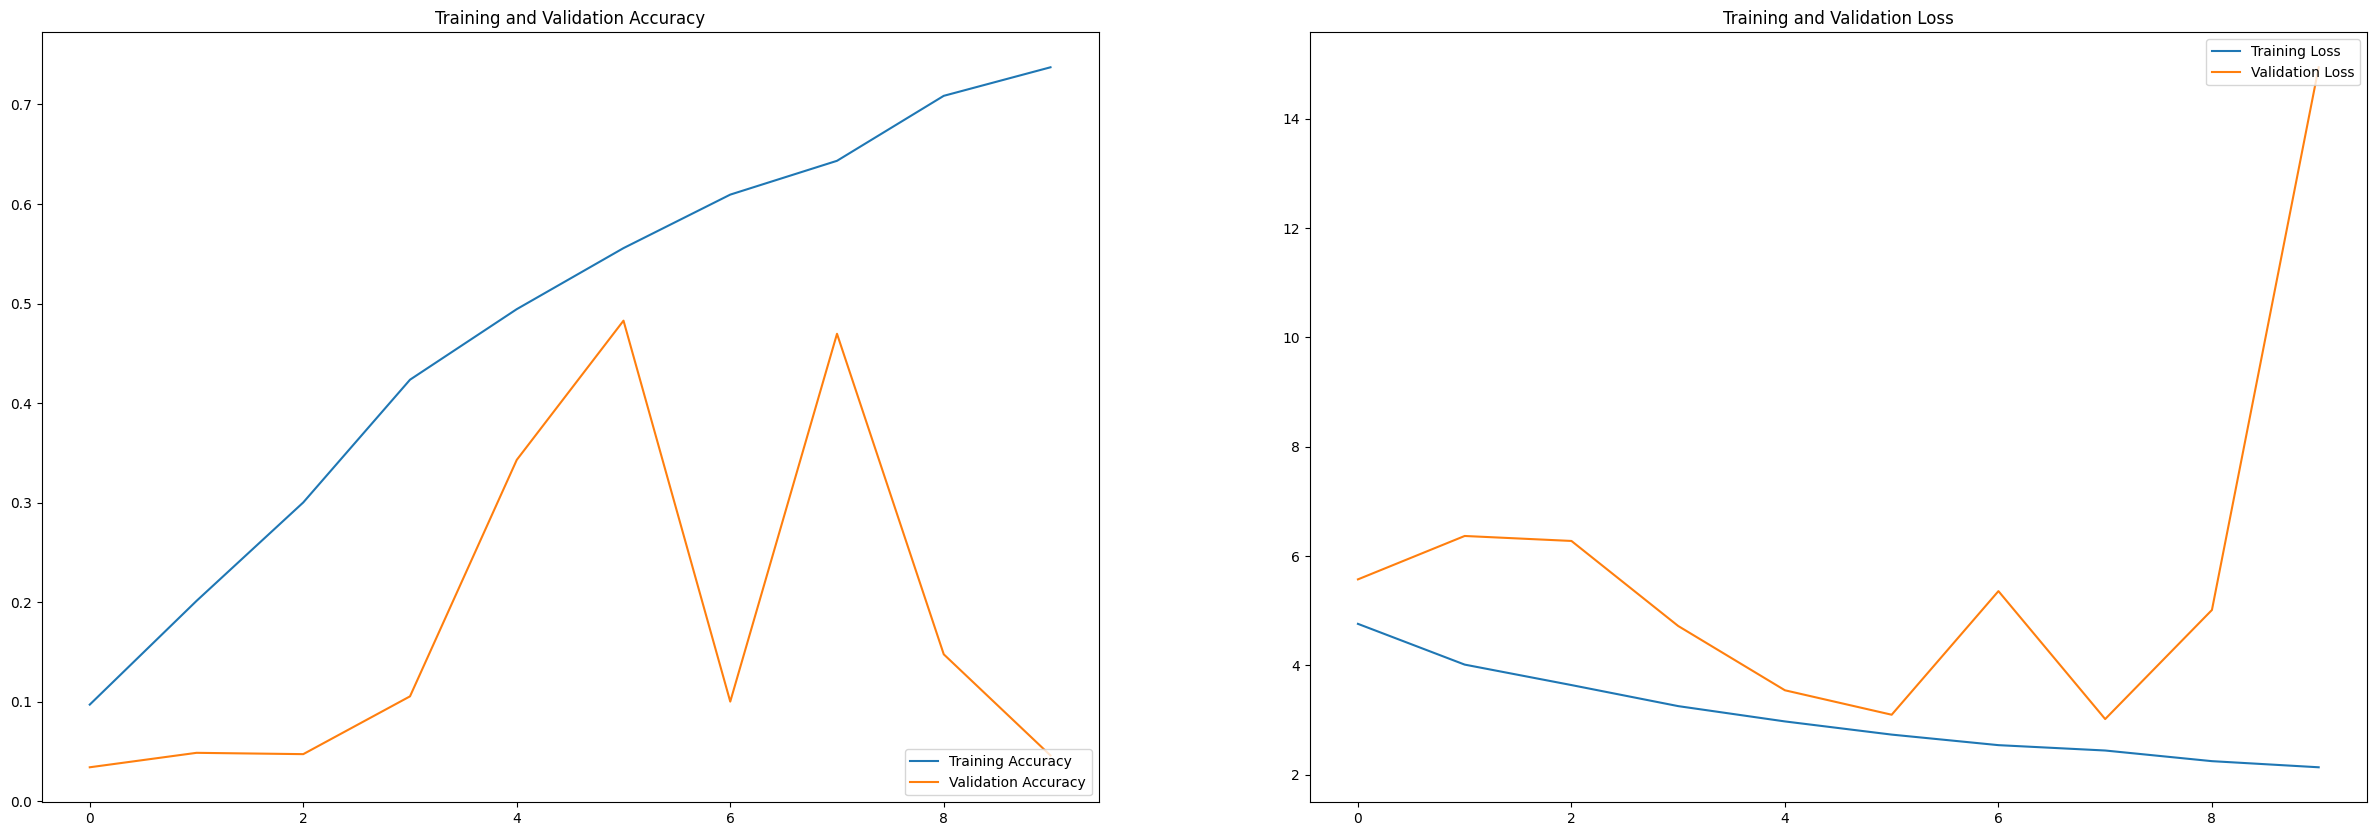

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(30, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()